
# MNIST Digit Classification with k-Nearest Neighbors (KNN)

This notebook presents a **comprehensive, end-to-end workflow** for classifying handwritten digits from the **MNIST** dataset using the **k-Nearest Neighbors (KNN)** algorithm.

We will cover:

- Loading and inspecting the MNIST dataset  
- Visualizing sample digits  
- Preprocessing and train–test splitting  
- Training a baseline KNN classifier  
- Evaluating performance (accuracy, confusion matrix, classification report)  
- Exploring the effect of the hyperparameter `k`  
- Measuring prediction time and discussing scalability  
- Using PCA for dimensionality reduction + KNN  
- Visualizing a 2D embedding of MNIST



> **Note on requirements & performance**
>
> - This notebook uses **scikit-learn** to fetch the MNIST dataset from OpenML. The dataset is automatically downloaded the first time you run it (internet connection required once).
> - The full MNIST dataset contains **70,000 images** (60,000 for training and 10,000 for testing). Running KNN on all 60,000 training samples can be **computationally expensive**, especially without GPU acceleration.
> - To keep experiments reasonably fast, we will **subsample** the training and test sets. You can increase these sizes later if your hardware can handle it.
>
> Required packages:
>
> ```bash
> pip install numpy pandas matplotlib scikit-learn
> ```


In [ ]:
# Core libraries
# This cell imports all the necessary libraries for data manipulation, visualization, and machine learning tasks.
# It includes libraries for numerical computations (NumPy), data handling (Pandas), plotting (Matplotlib), and various utilities from Scikit-learn for dataset fetching, model training, evaluation, and dimensionality reduction.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# Set random seed for reproducibility over entire notebook
np.random.seed(42)

# Scikit-learn utilities
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    accuracy_score
)
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Make plots appear inline
%matplotlib inline


## 1. Loading the MNIST Dataset

We load the MNIST dataset from OpenML via scikit-learn. Each sample is a **28×28 grayscale image**, flattened into a **784-dimensional vector**.


In [23]:
# Fetch the MNIST dataset from OpenML
# This will download the data the first time it is called.
# 784 features (28x28 images flattened) and 70000 samples.
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

X = mnist.data  #  data as numpy array (70000, 784) where each row is an image flattened to 784 pixels (28x28) 
y = mnist.target.astype(int)  # 70000 labels as integers (0-9) 

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print("Unique labels:", np.unique(y)) # Unique digit labels from 0 to 9

Shape of X: (70000, 784)
Shape of y: (70000,)
Unique labels: [0 1 2 3 4 5 6 7 8 9]



## 2. Basic Inspection and Visualization

Before training any model, it is essential to inspect the data:

- Check the shapes of inputs and labels.  
- Visualize some digit images.  
- Confirm that pixel values and labels look reasonable.


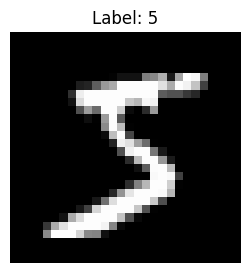

In [4]:
# Reshape a single sample to 28x28 to verify the image structure
sample_index = 0
sample_image = X[sample_index].reshape(28, 28)

plt.figure(figsize=(3, 3))
plt.imshow(sample_image, cmap='gray')
plt.title(f"Label: {y[sample_index]}")
plt.axis('off')
plt.show()

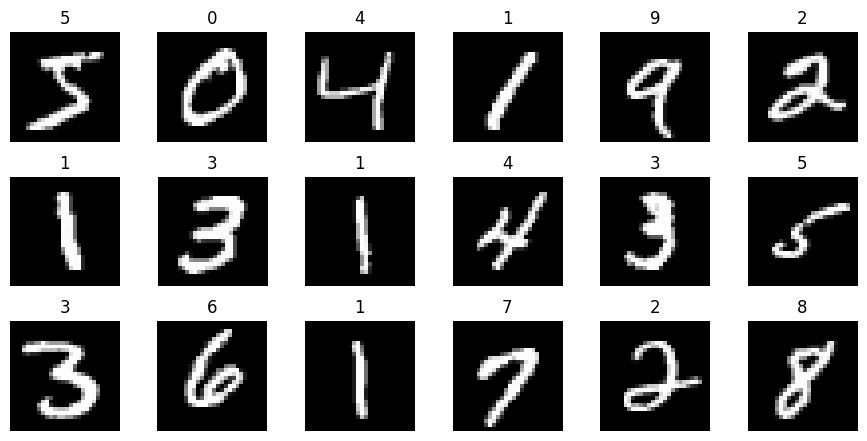

In [ ]:
# Visualize a grid of sample digits from the dataset that shows different digits and their labels. 
# This helps to understand the dataset better.
def plot_digit_grid(images, labels, n_rows=3, n_cols=6):
    plt.figure(figsize=(1.5 * n_cols, 1.5 * n_rows))
    for i in range(n_rows * n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        plt.title(str(labels[i]))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_digit_grid(X, y, n_rows=3, n_cols=6)


## 3. Train–Test Split and Subsampling

We now split the dataset into **training** and **test** sets.  
To keep KNN experiments computationally tractable, we will:

- use **20,000** samples for training,  
- use **5,000** samples for testing.

You can increase these values later if you want to match the full MNIST setup (60,000 train / 10,000 test), at the cost of significantly longer runtimes.


In [ ]:
# First, create a standard train/test split
# Stratify to maintain class distribution
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X, y,
    test_size=10000,     # full test set of 10,000 samples and 60,000 full training samples
    random_state=42,   # For reproducibility
    stratify=y
)

print("Full training set shape:", X_train_full.shape)
print("Full test set shape:", X_test_full.shape)

# Subsample for faster experimentation
n_train = 20000 # Use 20,000 samples from 60,000 for training
n_test = 5000    # Use 5,000 samples from 10,000 for testing

X_train = X_train_full[:n_train]
y_train = y_train_full[:n_train]

X_test = X_test_full[:n_test]
y_test = y_test_full[:n_test]


print("Subsampled training set shape:", X_train.shape)
print("Subsampled test set shape:", X_test.shape)

Full training set shape: (60000, 784)
Full test set shape: (10000, 784)
Subsampled training set shape: (20000, 784)
Subsampled test set shape: (5000, 784)



### 3.1. Simple Normalization

MNIST pixel values are in the range **0–255**. Since KNN relies on Euclidean distance in feature space, we normalize pixel values to the range **[0, 1]** by dividing by 255.


In [35]:
# Normalize pixel values to [0, 1]
# Normalization helps KNN perform better by ensuring all features contribute equally to distance calculations.
# 255 is the maximum pixel value for grayscale images.
X_train_scaled = X_train / 255.0
X_test_scaled = X_test / 255.0

print("Min / Max of X_train_scaled:", X_train_scaled.min(), X_train_scaled.max())

Min / Max of X_train_scaled: 0.0 1.0



## 4. Baseline KNN Classifier

We start with a baseline KNN classifier with:

- `n_neighbors = 3`  
- default Euclidean distance  
- uniform weights

We then evaluate test accuracy and analyze misclassifications using a confusion matrix and a classification report.


In [ ]:
# Train a baseline KNN classifier without dimensionality reduction
# Create and train a baseline KNN classifier with k=3 neighbors 
# without dimensionality reduction for comparison purposes.
knn_baseline = KNeighborsClassifier(n_neighbors=3)

start_time = time.time()                   # Measure fitting time start
knn_baseline.fit(X_train_scaled, y_train)  # Fit the model
fit_time = time.time() - start_time        # Measure fitting time end

print(f"Fitting took {fit_time:.2f} seconds")

Fitting took 0.03 seconds


In [82]:
# predict with 10th sample
sample_index = 10
sample_image = X_test_scaled[sample_index].reshape(1, -1)  # Reshape to 2D array for prediction. -1 infers the correct dimension for number of features.
predicted_label = knn_baseline.predict(sample_image)
print(f"- The lable of the Sample {sample_index} is <{y_test[sample_index]}>,  your prediction is <{predicted_label[0]}>  ==> {'Correct' if predicted_label[0] == y_test[sample_index] else 'Incorrect'}")

# Probability estimates for the sample
print("- Showing confidence for each digit class (0-9), where higher values indicate greater confidence.")
predicted_proba = knn_baseline.predict_proba(sample_image)
formatted = [[f"{p:.2f}" for p in row] for row in predicted_proba]              # Format probabilities to 2 decimal places
print(f"    Predicted probabilities for Sample {sample_index}:\n    {formatted}\n")



# predict with the 2486st sample
sample_index = 2486
sample_image = X_test_scaled[sample_index].reshape(1, -1)  # Reshape to 2D array for prediction. -1 infers the correct dimension for number of features.
predicted_label = knn_baseline.predict(sample_image)   
print(f"-The lable of the Sample {sample_index} is <{y_test[sample_index]}>,  your prediction is <{predicted_label[0]}> ==> {'Correct' if predicted_label[0] == y_test[sample_index] else 'Incorrect'}")

# Probability estimates for the sample
print("- Showing confidence for each digit class (0-9), where higher values indicate greater confidence.")
predicted_proba = knn_baseline.predict_proba(sample_image)
formatted = [[f"{p:.2f}" for p in row] for row in predicted_proba]                # Format probabilities to 2 decimal places
print(f"    Predicted probabilities for Sample {sample_index}:\n    {formatted}\n")





- The lable of the Sample 10 is <2>,  your prediction is <2>  ==> Correct
- Showing confidence for each digit class (0-9), where higher values indicate greater confidence.
    Predicted probabilities for Sample 10:
    [['0.00', '0.00', '1.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']]

-The lable of the Sample 2486 is <8>,  your prediction is <1> ==> Incorrect
- Showing confidence for each digit class (0-9), where higher values indicate greater confidence.
    Predicted probabilities for Sample 2486:
    [['0.00', '0.67', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.33', '0.00']]



In [87]:
# Evaluate on the test set for the baseline model
start_time = time.time()                                # Measure prediction time start
y_pred_baseline = knn_baseline.predict(X_test_scaled)   # Predict labels
pred_time = time.time() - start_time                    # Measure prediction time end


np_accuracy =np.mean(y_pred_baseline == y_test)                      # Calculate accuracy with boolean array
print(f"Baseline KNN (k=3) test accuracy (numpy): {np_accuracy:.4f}")  # Print accuracy

baseline_accuracy = accuracy_score(y_test, y_pred_baseline)                # Calculate accuracy with sklearn function
print(f"Baseline KNN (k=3) test accuracy (sklearn): {baseline_accuracy:.4f}")        # Print accuracy
print(f"Prediction on {len(y_test)} samples took {pred_time:.2f} seconds") # Print prediction time

Baseline KNN (k=3) test accuracy (numpy): 0.9552
Baseline KNN (k=3) test accuracy (sklearn): 0.9552
Prediction on 5000 samples took 1.82 seconds


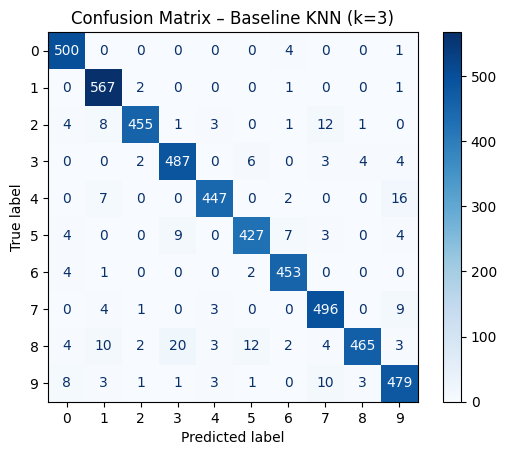

In [88]:
# Confusion matrix for baseline KNN
cm = confusion_matrix(y_test, y_pred_baseline, labels=range(10))              # 10 classes: 0 – 9 

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(values_format='d', cmap='Blues')                                    # d represents integer format
plt.title("Confusion Matrix – Baseline KNN (k=3)")
plt.show()



In [89]:
# Classification report 
# Detailed precision, recall, and F1-score for each class
# precision = TP / (TP + FP)
# recall = TP / (TP + FN)
# F1-score = 2 * (precision * recall) / (precision + recall)
print("Classification report for baseline KNN (k=3):")
print(classification_report(y_test, y_pred_baseline, digits=4))

Classification report for baseline KNN (k=3):
              precision    recall  f1-score   support

           0     0.9542    0.9901    0.9718       505
           1     0.9450    0.9930    0.9684       571
           2     0.9827    0.9381    0.9599       485
           3     0.9402    0.9625    0.9512       506
           4     0.9739    0.9470    0.9603       472
           5     0.9531    0.9405    0.9468       454
           6     0.9638    0.9848    0.9742       460
           7     0.9394    0.9669    0.9529       513
           8     0.9831    0.8857    0.9319       525
           9     0.9265    0.9411    0.9337       509

    accuracy                         0.9552      5000
   macro avg     0.9562    0.9550    0.9551      5000
weighted avg     0.9558    0.9552    0.9550      5000




### 4.1. Inspecting Individual Predictions

To build intuition about model behavior, we inspect a few correctly and incorrectly classified samples.


Number of misclassified samples: 224


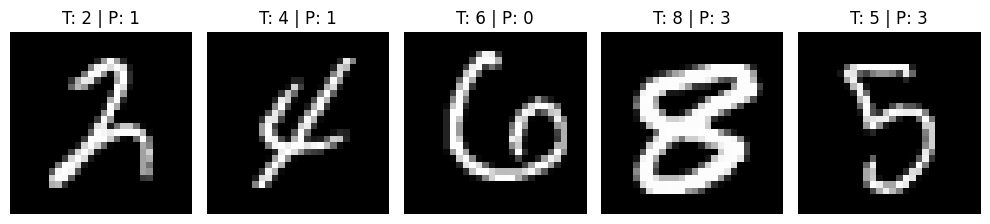

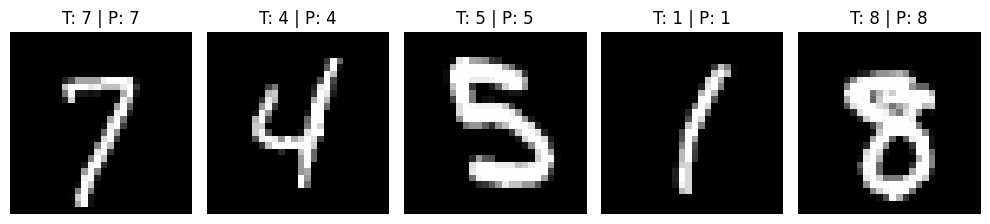

In [93]:
# Helper function to visualize predictions
# Show images with true and predicted labels
def show_predictions(images, true_labels, pred_labels, indices):
    n = len(indices)
    plt.figure(figsize=(2 * n, 2.5))
    for i, idx in enumerate(indices):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[idx].reshape(28, 28), cmap='gray')         # Reshape data to 28x28 to display as image in grayscale 
        plt.title(f"T: {true_labels[idx]} | P: {pred_labels[idx]}")  # True vs Predicted 
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Find some misclassified examples
misclassified_indices = np.where(y_test != y_pred_baseline)[0]        # Indices of misclassified samples. [0] meaning we take the first element of the tuple returned by np.where
print("Number of misclassified samples:", len(misclassified_indices)) # Print number of misclassified samples among test set which is 5000

if len(misclassified_indices) > 0:   # Only show if there are misclassifications. 0 means no misclassifications
    show_predictions(X_test, y_test, y_pred_baseline, misclassified_indices[:5])   # Show first 5 find misclassified samples

# Show some correctly classified examples for comparison
correct_indices = np.where(y_test == y_pred_baseline)[0]                           # [0] meaning we take the first element of the tuple returned by np.where
show_predictions(X_test, y_test, y_pred_baseline, correct_indices[:5])             # Show first 5 first correctly classified samples


## 5. Effect of the Hyperparameter `k`

We now investigate how the choice of `n_neighbors` affects performance.  
We will:

- vary `k` from 1 to 11 (odd values),  
- record training and test accuracy,  
- visualize accuracy as a function of `k`.

This illustrates overfitting at very small `k` and underfitting at very large `k`.


In [94]:
k_values = list(range(1, 12, 2))  # 1, 3, 5, ..., 11
train_accuracies = []
test_accuracies = []
fit_times = []
pred_times = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    start_fit = time.time()
    knn.fit(X_train_scaled, y_train)
    fit_times.append(time.time() - start_fit)
    
    # Accuracy on training set
    y_train_pred = knn.predict(X_train_scaled)
    train_acc = accuracy_score(y_train, y_train_pred)
    train_accuracies.append(train_acc)
    
    # Accuracy on test set
    start_pred = time.time()
    y_test_pred = knn.predict(X_test_scaled)
    pred_times.append(time.time() - start_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    test_accuracies.append(test_acc)
    
    print(f"k={k:2d} | train acc={train_acc:.4f} | test acc={test_acc:.4f} | "
          f"fit={fit_times[-1]:.2f}s | pred={pred_times[-1]:.2f}s")

k= 1 | train acc=1.0000 | test acc=0.9598 | fit=0.03s | pred=1.67s
k= 3 | train acc=0.9812 | test acc=0.9544 | fit=0.04s | pred=1.58s
k= 5 | train acc=0.9758 | test acc=0.9542 | fit=0.03s | pred=1.72s
k= 7 | train acc=0.9701 | test acc=0.9522 | fit=0.03s | pred=1.72s
k= 9 | train acc=0.9675 | test acc=0.9480 | fit=0.03s | pred=1.61s
k=11 | train acc=0.9645 | test acc=0.9444 | fit=0.02s | pred=1.57s


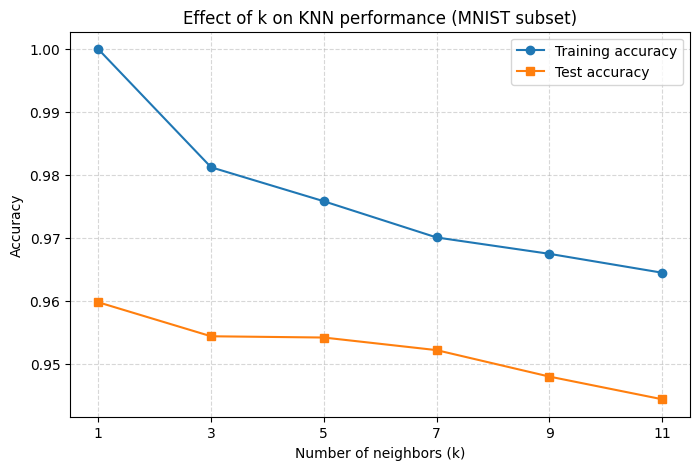

In [95]:
# Plot training and test accuracy vs k
plt.figure(figsize=(8, 5))
plt.plot(k_values, train_accuracies, marker='o', label='Training accuracy')
plt.plot(k_values, test_accuracies, marker='s', label='Test accuracy')
plt.xlabel("Number of neighbors (k)")
plt.ylabel("Accuracy")
plt.title("Effect of k on KNN performance (MNIST subset)")
plt.xticks(k_values)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()


## 6. Dimensionality Reduction with PCA + KNN

The original MNIST feature space has 784 dimensions. High-dimensional spaces can:

- increase computational cost,  
- add noise,  
- distort distances used by KNN.

We use **Principal Component Analysis (PCA)** to project the data into a lower-dimensional space (e.g., 50 dimensions), then train KNN in that reduced space.

We evaluate both accuracy and prediction time.

PCA is applied before KNN because the MNIST dataset is extremely high-dimensional (784 features per image), and KNN relies entirely on distance calculations that become unreliable in such large feature spaces. In high dimensions, Euclidean distances tend to lose discriminative power because all points become similarly distant from one another, a phenomenon known as the curse of dimensionality. By reducing the data to a smaller number of PCA components—such as 50—we retain the majority of the meaningful variance in the images while removing noise and redundant dimensions. This not only improves the quality of the feature space used for distance comparisons but also makes KNN much faster, since both memory usage and computation scale directly with the number of features. PCA therefore provides a more compact, informative representation of the data, enabling KNN to achieve better accuracy, faster prediction time, and improved generalization. In essence, PCA transforms MNIST from a noisy, high-dimensional pixel space into a cleaner, lower-dimensional structure where KNN can operate effectively.


In [ ]:
# Define a pipeline: PCA (50 components) + KNN
n_components = 50

# Create a pipeline that first reduces dimensionality with PCA, then applies KNN classifier with k=3 neighbors.
# The random_state in PCA ensures reproducibility of results.
# The pipeline allows for streamlined fitting and prediction.
# 50 components capture most variance while reducing computational load.
# This is crucial for KNN which is sensitive to high dimensionality.
# The pipeline encapsulates the two-step process into a single model object.
pca_knn = Pipeline([
    ('pca', PCA(n_components=n_components, random_state=42)),         # Dimensionality reduction to 50 components. random_state for reproducibility
    ('knn', KNeighborsClassifier(n_neighbors=3))
])

start_fit = time.time()                                              # Measure fitting time start
pca_knn.fit(X_train_scaled, y_train)                                 # Fit the model with PCA + KNN
fit_time_pca = time.time() - start_fit                               # Measure fitting time end

start_pred = time.time()                                             # Measure prediction time start
y_pred_pca = pca_knn.predict(X_test_scaled)                          # Predict labels with PCA + KNN
pred_time_pca = time.time() - start_pred                             # Measure prediction time end

accuracy_pca = accuracy_score(y_test, y_pred_pca)                    # Calculate accuracy

# Print results for PCA + KNN
print(f"PCA+KNN (50 components, k=3) test accuracy (sklearn): {accuracy_pca:.4f}")
print(f"Fitting time (PCA+KNN): {fit_time_pca:.2f} seconds")
print(f"Prediction time (PCA+KNN): {pred_time_pca:.2f} seconds")

PCA+KNN (50 components, k=3) test accuracy (sklearn): 0.9630
Fitting time (PCA+KNN): 0.55 seconds
Prediction time (PCA+KNN): 0.25 seconds



### 6.1. 2D Visualization of MNIST with PCA

For visualization purposes, we project a subset of MNIST onto **2 principal components** and plot:

- each point as a digit sample,  
- colors corresponding to digit classes.

This gives a coarse idea of how different classes cluster in a low-dimensional space.


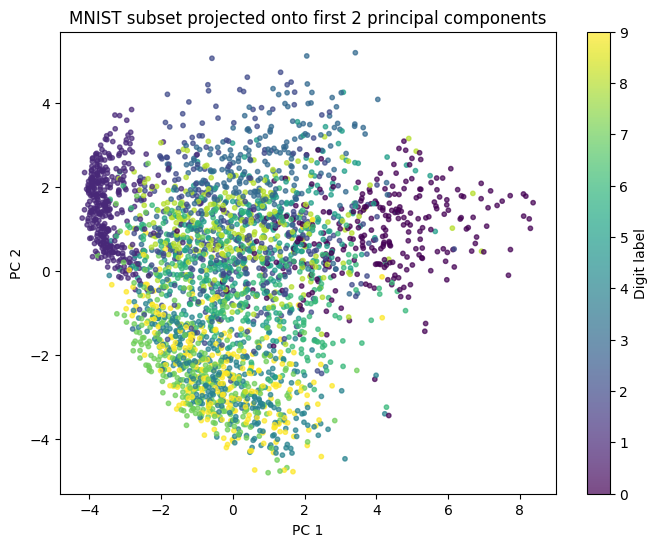

In [101]:
# Use a subset for 2D visualization to avoid overcrowding the plot
subset_size = 3000
X_vis = X_train_scaled[:subset_size]              # Subset of training data for visualization
y_vis = y_train[:subset_size]                     # Subset of training labels for visualization

pca_2d = PCA(n_components=2, random_state=42)     # Dimensionality reduction to 2 components for visualization
X_vis_2d = pca_2d.fit_transform(X_vis)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_vis_2d[:, 0], X_vis_2d[:, 1], c=y_vis, s=10, alpha=0.7)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("MNIST subset projected onto first 2 principal components")
cbar = plt.colorbar(scatter, ticks=range(10))
cbar.set_label('Digit label')
plt.show()


## 7. Summary and Discussion

In this notebook, we:

- Loaded and inspected the MNIST dataset (70,000 samples, 784 features).  
- Visualized example digits to build intuition about the data.  
- Performed a train–test split and normalized pixel values to [0, 1].  
- Trained a baseline KNN classifier and evaluated it using accuracy, confusion matrix, and classification report.  
- Investigated the impact of the hyperparameter `k` on training/testing accuracy and runtime.  
- Observed that KNN can achieve high accuracy on MNIST but is computationally expensive for large datasets.  
- Applied PCA for dimensionality reduction (e.g., 50 components) and showed that PCA+KNN can provide a good trade-off between accuracy and runtime.  
- Visualized a 2D PCA projection of a subset of MNIST to understand class structure in a reduced space.

KNN is conceptually simple and often strong on smaller or low-dimensional datasets, but its computational cost grows with both the number of training samples and the dimensionality of the feature space.  
For large-scale applications, approximate nearest neighbor methods or alternative classifiers (e.g., logistic regression, SVMs, or neural networks) are typically preferred.
